# Ordered Logistics Regression
Bs. Vương Kiến Thanh

**Ordered Logistics Regression (OLR)** được dùng trong tình huống outcome là một biến phân nhóm mà có thứ tự.

Kết cục phân nhóm có thứ tự (ordered categorical outcome) không phải là số đếm. Sự khác nhau giữa hai mức độ không phải là bằng đều nhau. Xem chúng như là biến liên tục cũng không phải là ý tưởng tốt.

Theo nguyên tắc, biến phân nhóm có thứ tự thực chất cũng là hồi quy multinomial, nhưng với sự ràng buộc  trật tự của biến. Mục đích của chúng ta là khi một biến dự đoán tương quan dương có giá trị tăng lên, mô hình nên dự đoán thiên về phía có thứ tự cao hơn.

Giả sử outcome có $n$ nhóm. Cách thức hoạt động của OLR như sau:
1. Bản chất của OLR là multinomial distribution, với tham số là vector $p[k]$, với $k=n-1$.
2. Vector $p[k]$ sẽ chuyển sang dạng xác suất tích luỹ, vector $q[k]$, có đặc điểm $q_0 <q_1<\dots<q_k$. Xác suất tích luỹ của thứ tự cao nhất luôn luôn là $q_n=1$.
3. Vector $q[k]$ chuyển sang dạng logit (hay log-odds) tích luỹ, vector $logit[k]$.
4. Từng logit tích luỹ được gán cho một hàm số tuyến tính với intercept tương ứng, gọi là cut points, tạo thành vector $cut points[k]$

Như vậy, chúng ta cần prior cho:
- $cutpoints[k]$, $k=n-1$
- beta cho các hiệp biến

Mô hình toán học:
$$\begin{aligned}
R_i &\sim \text{Multinomial}(p)\\
p_1&=q_1\\
p_k &= q_k - q_{k-1}\\
p_K &= 1 - q_{k-1}\\
logit(q_k) &= \text{cutpoints}_k - \phi_i\\
\phi_i &= \text{linear model}\\
\end{aligned}$$

Dấu trừ ở logit tích luỹ là để xác suất đi về phía thứ tự cao hơn khi $\phi$ tăng lên.
## Thực hành
Source: https://www.gagolewski.com/resources/data/ordinal-regression/

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
import numpyro.distributions as dist
from numpyro.distributions.transforms import OrderedTransform
from numpyro.infer import MCMC, NUTS, Predictive
import jax.numpy as jnp
from jax.scipy.special import expit
from jax import random, vmap
import arviz as az
from sklearn.preprocessing import StandardScaler
az.style.use('fivethirtyeight')

### Preprocessing

In [204]:
df = pd.read_csv('https://www.gagolewski.com/resources/data/ordinal-regression/machine_ord.csv')
df

,response,V1,V2,V3,V4,V5,V6
0,1,400,1000,3000,0,1,2
1,1,400,512,3500,4,1,6
2,1,350,64,64,0,1,4
3,1,200,512,16000,0,4,32
4,1,167,524,2000,8,4,15
...,...,...,...,...,...,...,...
194,10,23,32000,64000,128,32,64
195,10,38,16000,32000,128,16,32
196,10,30,16000,32000,256,16,24
197,10,30,8000,64000,96,12,176


#### Kiểm tra non-null, size, dtype

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   response  199 non-null    int64
 1   V1        199 non-null    int64
 2   V2        199 non-null    int64
 3   V3        199 non-null    int64
 4   V4        199 non-null    int64
 5   V5        199 non-null    int64
 6   V6        199 non-null    int64
dtypes: int64(7)
memory usage: 11.0 KB


#### Số lượng nhóm trong outcome

In [207]:
df['response'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

#### Scale lại về mean=0, std=1; để optimize MCMC sampling

In [281]:
scalers = dict()
for c in df.columns[1:]:
    scalers[c]=StandardScaler()
    df[c]= scalers[c].fit_transform(df[c].values.reshape(-1,1))
scalers.keys()

dict_keys(['V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

In [282]:
df.head()

,response,V1,V2,V3,V4,V5,V6
0,1,0.819983,-0.498540,-0.757524,-0.632872,-0.559808,-0.639393
1,1,0.819983,-0.622485,-0.715566,-0.535920,-0.559808,-0.487917
2,1,0.621317,-0.736271,-1.003903,-0.632872,-0.559808,-0.563655
3,1,0.025317,-0.622485,0.333391,-0.632872,-0.126338,0.496671
4,1,-0.105802,-0.619437,-0.841440,-0.438967,-0.126338,-0.147098


### Mô tả mechanism của ordered logistics

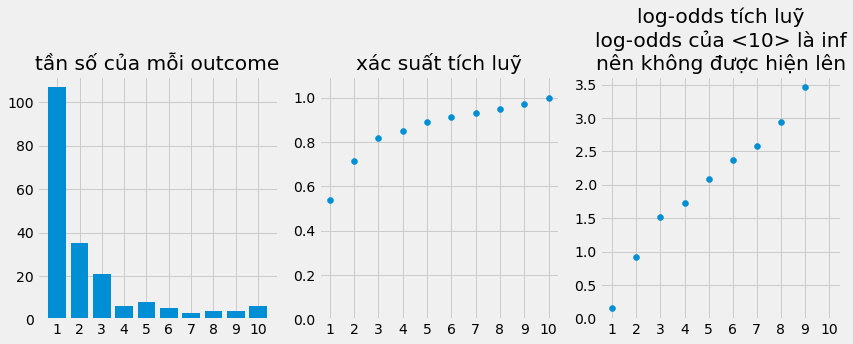

In [213]:
logit = lambda x: np.log(x/(1-x))
freq = df.groupby('response').size()
names = freq.index.values
cumsum = freq.cumsum()
cumprob = cumsum/ df.shape[0]
cumlogodd= logit(cumprob)
r = np.max(df['response'])
_, axes = plt.subplots(1,3, figsize=(12,5))
axes[0].bar(names,freq)
axes[1].scatter(names, cumprob)
axes[2].scatter(names,cumlogodd)

axes[0].set(title="tần số của mỗi outcome", xticks=range(1,r+1))
axes[1].set(title="xác suất tích luỹ", ylim=(0,1.1),xticks=range(1,r+1))
axes[2].set(title=f"log-odds tích luỹ\nlog-odds của <{r}> là inf\nnên không được hiện lên",
            xticks=range(1,r+1), xlim=(0.5,r+.5))
plt.tight_layout()

### Mô hình, và lấy mẫu bằng MCMC:
Mô hình của chúng ta có thể thu gọn lại thành, ở dạng Toán học:
$$\begin{aligned}
\text{response} &\sim \text{OrderedLogistics}(\text{cutpoints}, \phi)\\
\text{cutpoints[9]} &\sim \text{Normal}(0,1)\\
\phi &= \beta \times V^T\\
\beta &\sim \text{Normal}(0,1)\\
\end{aligned}$$

In [239]:
k = len(df['response'].unique())-1
v = len(df.columns)-1
def model(V, response=None):
    # prior for covariates and cutpoints
    bV = numpyro.sample("bV", dist.Normal(0, 1).expand([v]))
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1).expand([k]), OrderedTransform()
        ))
    # linear model
    phi = numpyro.deterministic("phi", bV@V.T)
    # likelihood
    numpyro.sample("response", dist.OrderedLogistic(phi, cutpoints), obs=response)

In [240]:
data = {
    "V": df.iloc[:,1:].values,
    "response": df['response'].values-1
}
mcmc = MCMC(NUTS(model), 500, 2000, 4, chain_method='sequential')
mcmc.run(random.PRNGKey(1), **data )

sample: 100%|██████████| 2500/2500 [00:04<00:00, 577.85it/s, 17 steps of size 1.15e-01. acc. prob=0.80]


In [241]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       bV[0]     -0.24      0.22     -0.24     -0.60      0.14    308.29      1.02
       bV[1]      1.38      0.27      1.38      0.93      1.82    338.94      1.03
       bV[2]      1.85      0.29      1.84      1.38      2.31    350.48      1.01
       bV[3]      1.30      0.24      1.30      0.92      1.71    371.47      1.01
       bV[4]      0.25      0.20      0.26     -0.07      0.57    277.28      1.02
       bV[5]      0.11      0.22      0.11     -0.31      0.45    365.53      1.02
cutpoints[0]     -0.75      0.23     -0.76     -1.16     -0.39    271.18      1.03
cutpoints[1]      1.28      0.27      1.28      0.85      1.75    345.28      1.01
cutpoints[2]      3.46      0.39      3.45      2.78      4.06    485.60      1.01
cutpoints[3]      4.26      0.43      4.26      3.59      5.02    487.72      1.01
cutpoints[4]      5.42      0.50      5.41      4.57      6.23    441.58      1.01
cut

#### Kiểm tra convergence:
MCMC có divergence khá cao (tức là sampling chưa hiệu quả), r_hat cũng chưa tốt, nhưng trace và forest trông cũng khá converge -> chấp nhận.

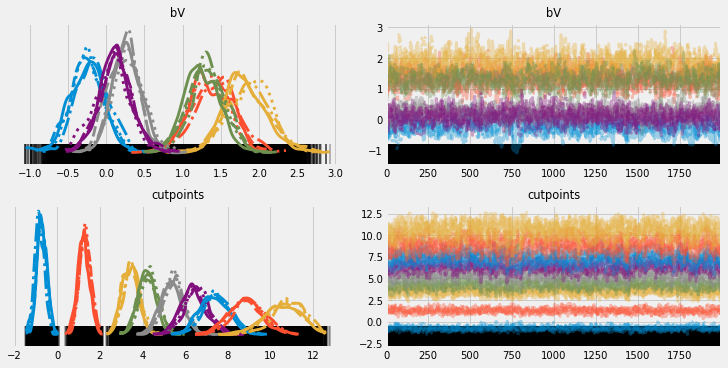

In [246]:
az.plot_trace(az.from_numpyro(mcmc), var_names=['bV','cutpoints'], figsize=(10,5));

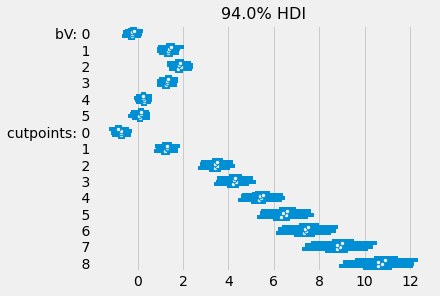

In [247]:
az.plot_forest(az.from_numpyro(mcmc), var_names=['bV','cutpoints'], figsize=(6,4));

### Kiểm tra fit của mô hình

In [248]:
pred_data = {
    "V":df.iloc[:,1:].values,
}
post = mcmc.get_samples()
y_preds = Predictive(mcmc.sampler.model, post)(
    random.PRNGKey(3), **pred_data
)

Dự đoán của mô hình (tôi cũng hiện đồng thời y_true)

In [297]:
y_pred = y_preds['response'].mean(0).round(0)+1
y_pred

DeviceArray([ 1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
              1.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,
              1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
              1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
              1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
              1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
              1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
              2.,  2.,  2.,  2.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,
              1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
              1.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,
              1.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,
              2.,  2.,  3.,  3.,  4.,  1.,  1.,  2.,  2.,  1.,  3.,  3.,
              4.,  3.,  2.,  2.,  3.,  3.,  4.,  2.,  3.,  4.,  3.,  3.,
              1.,  2.,  8.,  2.,  3.,  2.,  4.,  6.

In [265]:
# y_true
df['response'].values

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10])

#### Độ chính xác của mô hình

In [280]:
sum(y_pred == df['response'].values)/df.shape[0]

0.6834170854271356

#### Tổng quan dự đoán

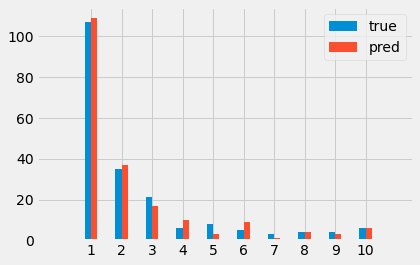

In [299]:
plt.hist(df['response'].values, width=0.2, bins=np.arange(0,12)-0.2, label='true')
plt.hist(y_preds['response'].mean(0).round(0)+1, width=0.2, bins=np.arange(1,12), label='pred')
plt.xticks(range(1,11))
plt.legend()

---

## Kết luận:
Mô hình hoạt động tốt ở những giá trị outcome có số mẫu lớn, và ngược lại với những nơi có ít mẫu (như 10).  
Diễn giải mô hình cũng khó khăn hơn, vì mọi tham số đều ở thang log-odds. Bạn có thể chuyển về dạng odds-ratio, nhưng nó vẫn còn khá trừu tượng.  
Nhưng nếu mọi giả định của mô hình đều đúng (tính thứ tự của biến phân nhóm) thì chắc chắn mô hình sẽ mạnh mẽ hơn nhưng mô hình multinomial (không ordered) hoặc Ordinary Linear Regression.
